In [76]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re, math

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

from IPython.display import HTML, display

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
from numpy import linspace
from matplotlib.colors import LogNorm
from decimal import *

Minimum Final AVG Std Dev: Trajectory 7 (0.009101)
Minimum Final MAX Std Dev: Trajectory 7 (0.018782)
Minimum Final VAR Reach: Trajectory 50 (0.000000)
Minimum AVG Future Std Dev: Trajectory 22 (0.142291)
0 std:  0.0723496420341
1 std:  0.0630046644624
2 std:  0.0745956689315
3 std:  0.133092234893
4 std:  0.299353867149
5 std:  0.0226215474505
6 std:  0.0280625717821
7 std:  0.0753408306091
8 std:  0.0515978167704
9 std:  0.0850206184086
10 std:  0.0344980643427
11 std:  0.790379377353
12 std:  0.0226423313847
13 std:  0.0477126743235
14 std:  0.0470060054485
15 std:  0.0292079091977
16 std:  0.0776604197487
17 std:  0.0211760553547
18 std:  0.023379234925
19 std:  0.128245692806
20 std:  0.0752078411053
21 std:  0.0355075410714
22 std:  0.0260446591556
23 std:  0.0771130016517
24 std:  0.0332427562383
25 std:  0.0329351479007
26 std:  0.106875339304
27 std:  0.0627272968837
28 std:  0.0627890190215


,T 0,T 1,T 2,T 3,T 4,T 5,T 6,T 7,T 8,T 9,T 10,T 11,T 12,T 13,T 14,T 15,T 16,T 17,T 18,T 19,T 20,T 21,T 22,T 23,T 24,T 25,T 26,T 27,T 28,T 29,T 30,T 31,T 32,T 33,T 34,T 35,T 36,T 37,T 38,T 39,T 40,T 41,T 42,T 43,T 44,T 45,T 46,T 47,T 48,T 49,T 50,T 51,T 52,T 53
Voxels,17,19,21,18,19,21,20,19,22,19,19,23,20,21,23,19,21,23,20,21,23,22,22,25,22,21,24,24,23,26,22,23,25,24,25,27,24,25,27,24,24,27,25,24,28,26,25,28,25,27,29,25,26,29
Last AVG Std,0.014,0.014,0.016,0.012,0.019,0.024,0.015,0.009,0.029,0.021,0.015,0.021,0.019,0.025,0.033,0.015,0.012,0.020,0.011,0.017,0.016,0.013,0.013,0.017,0.025,0.021,0.036,0.025,0.011,0.016,0.016,0.017,0.031,0.020,0.023,0.035,0.030,0.017,0.020,0.021,0.020,0.020,0.020,0.012,0.022,0.018,0.020,0.018,0.021,0.021,0.023,0.021,0.020,0.025
Last MAX Std,0.099,0.039,0.097,0.060,0.105,0.163,0.063,0.019,0.151,0.138,0.032,0.107,0.042,0.139,0.229,0.041,0.022,0.076,0.057,0.161,0.092,0.041,0.046,0.138,0.086,0.077,0.161,0.125,0.029,0.081,0.038,0.058,0.195,0.084,0.069,0.244,0.105,0.053,0.089,0.106,0.085,0.131,0.103,0.028,0.135,0.079,0.150,0.071,0.070,0.117,0.198,0.104,0.084,0.135
Last VAR Reach,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
AVG Future Std,0.160,0.165,0.173,0.155,0.171,0.169,0.158,0.162,0.187,0.165,0.185,0.177,0.206,0.211,0.222,0.186,0.191,0.193,0.146,0.148,0.166,0.164,0.142,0.155,0.185,0.188,0.203,0.184,0.152,0.167,0.174,0.176,0.203,0.194,0.193,0.199,0.187,0.165,0.182,0.173,0.183,0.174,0.166,0.161,0.193,0.161,0.182,0.182,0.189,0.191,0.175,0.178,0.183,0.187


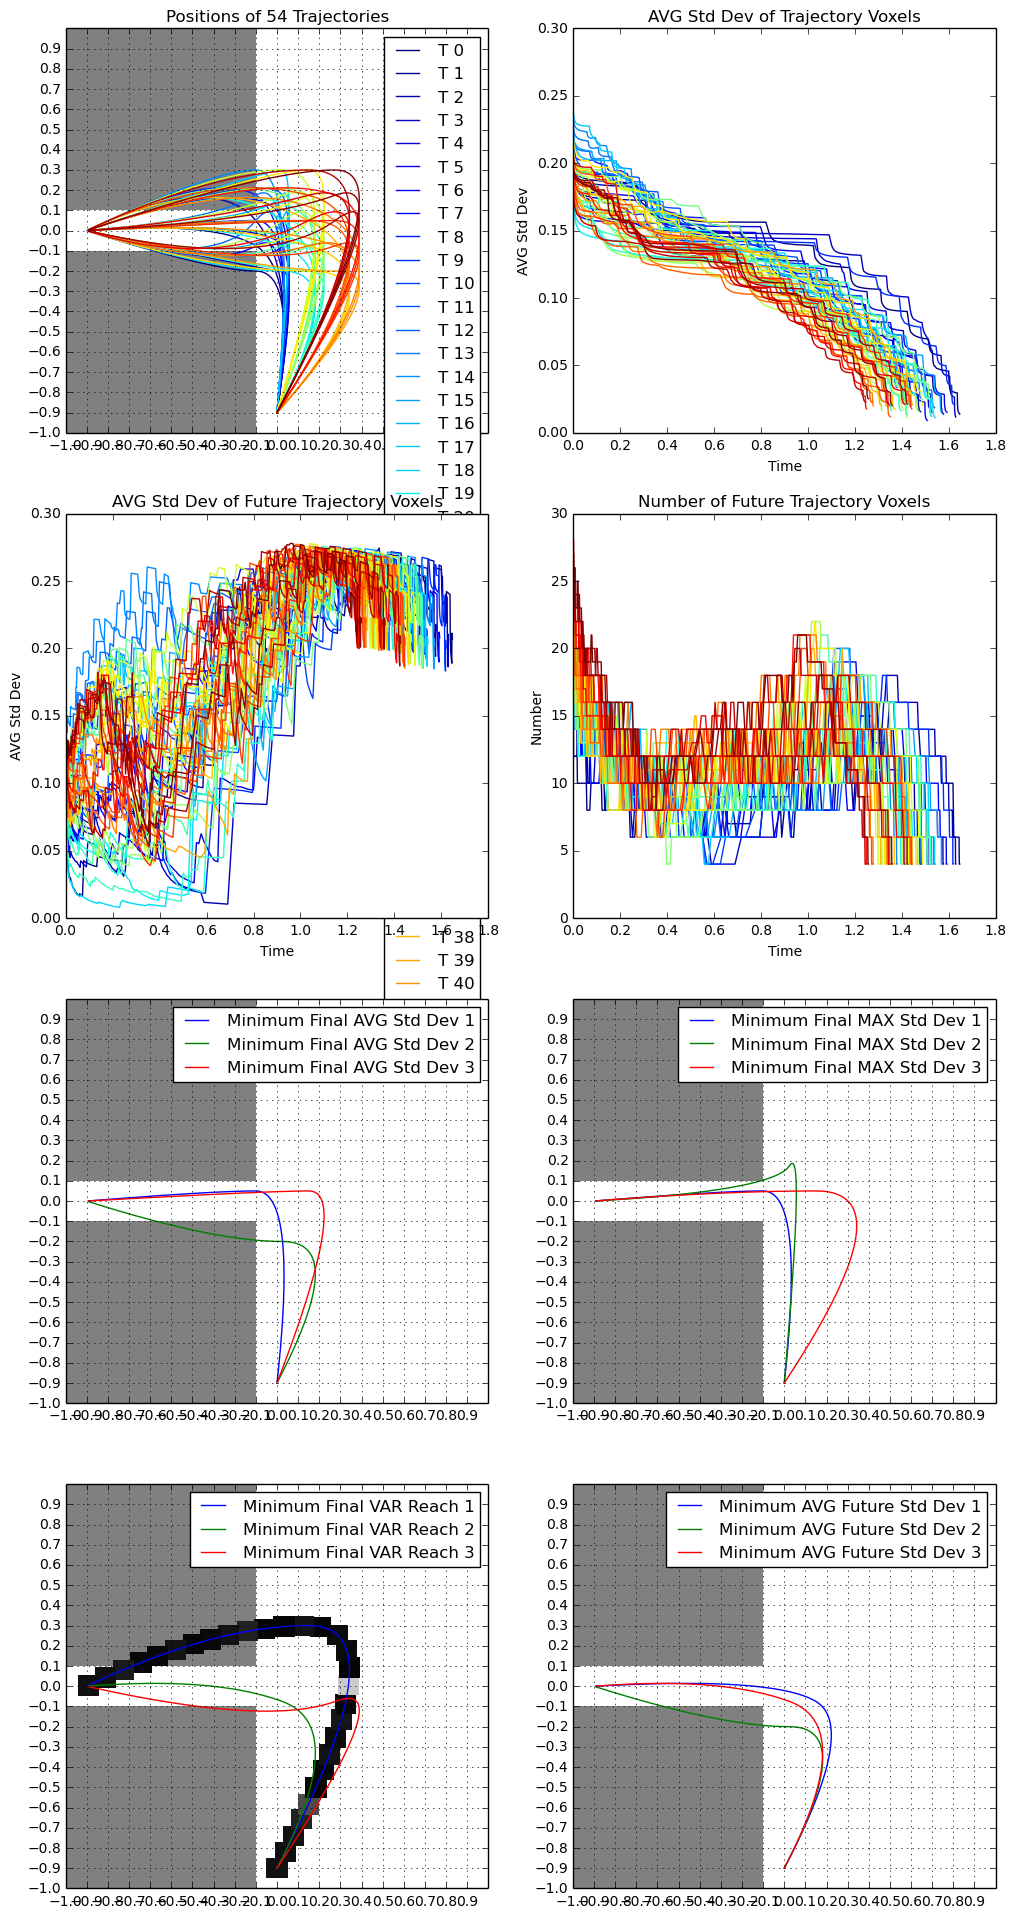

In [117]:
%matplotlib inline

getcontext().prec = 128

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 24))

verts1 = [
    (-1, -1), # left, bottom
    (-1, -.1), # left, top
    (-.1, -.1), # right, top
    (-.1, -1), # right, bottom
    (0., 0.), # ignored
]

verts2 = [
    (-1, .1), # left, bottom
    (-1, 1), # left, top
    (-.1, 1), # right, top
    (-.1, .1), # right, bottom
    (0., 0.), # ignored
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

ax1.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax1.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax1.set_xticks(np.arange(-1,1,0.1))
ax1.set_yticks(np.arange(-1,1,0.1))
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.grid()

ax5.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax5.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax5.set_xticks(np.arange(-1,1,0.1))
ax5.set_yticks(np.arange(-1,1,0.1))
ax5.set_xlim([-1, 1])
ax5.set_ylim([-1, 1])
ax5.grid()

ax6.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax6.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax6.set_xticks(np.arange(-1,1,0.1))
ax6.set_yticks(np.arange(-1,1,0.1))
ax6.set_xlim([-1, 1])
ax6.set_ylim([-1, 1])
ax6.grid()

ax7.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax7.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax7.set_xticks(np.arange(-1,1,0.1))
ax7.set_yticks(np.arange(-1,1,0.1))
ax7.set_xlim([-1, 1])
ax7.set_ylim([-1, 1])
ax7.grid()

ax8.add_patch(patches.PathPatch(Path(verts1, codes), facecolor='grey', lw=0))
ax8.add_patch(patches.PathPatch(Path(verts2, codes), facecolor='grey', lw=0))
ax8.set_xticks(np.arange(-1,1,0.1))
ax8.set_yticks(np.arange(-1,1,0.1))
ax8.set_xlim([-1, 1])
ax8.set_ylim([-1, 1])
ax8.grid()

filenames = sorted(glob.glob("../build/trajeval/*.bag"), key=lambda f: int(re.findall('([0-9]+)', f)[0]))

cm_subsection = linspace(0, 1, len(filenames))
colors = [cm.jet(x) for x in cm_subsection]


ax1.set_title("Positions of %i Trajectories" % len(filenames))

ax2.set_title("AVG Std Dev of Trajectory Voxels")
ax2.set_xlabel("Time")
ax2.set_ylabel("AVG Std Dev")

ax3.set_title("AVG Std Dev of Future Trajectory Voxels")
ax3.set_xlabel("Time")
ax3.set_ylabel("AVG Std Dev")

ax4.set_title("Number of Future Trajectory Voxels")
ax4.set_xlabel("Time")
ax4.set_ylabel("Number")

traj_names = [""]
avg_stds = []
avg_future_stds = []
max_stds = []
last_var_reachability = []
traj_voxels = []

def argmin(array):
    m = 0
    for i, a in enumerate(array):
        if a < array[m]:
            m = i
    return m

def argmins(array, n=3):
    pairs = sorted(zip(array, range(len(array))), key=lambda x: x[0])
    return list(map(lambda x: x[1], pairs[:n]))

def argmax(array):
    m = 0
    for i, a in enumerate(array):
        if a > array[m]:
            m = i
    return m

all_stats = []

def plot_spline(ax, stats, name, rnd, random_color=False):
    if random_color:
        ax.plot(stats.trajectoryX, stats.trajectoryY, label=name)
    else:
        ax.plot(stats.trajectoryX, stats.trajectoryY, label=name, c=colors[rnd])
        
def draw_final_stds(ax, stats, voxel_size=0.1):
    last_stds = stats.trajectoryStdDevsBelief[-stats.trajectoryVoxels:]
    hvoxel_size = voxel_size / 2.
    for i, std in enumerate(last_stds):
        std *= 4
        print i, "std: ", std
        x = (stats.trajectoryX[int((i)*1./(len(last_stds)-1)*stats.step)] / voxel_size) * voxel_size
        y = (stats.trajectoryY[int((i)*1./(len(last_stds)-1)*stats.step)] / voxel_size) * voxel_size
        verts = [
            (x - hvoxel_size, y - hvoxel_size), # left, bottom
            (x - hvoxel_size, y + hvoxel_size), # left, top
            (x + hvoxel_size, y + hvoxel_size), # right, top
            (x + hvoxel_size, y - hvoxel_size), # right, bottom
            (0., 0.), # ignored
        ]
        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]
        ax.add_patch(patches.PathPatch(Path(verts, codes), facecolor=str(std), lw=0))

for rnd, filename in enumerate(filenames):
    #if rnd != 7:
     #   continue
#     if rnd != 50:
#         continue
    
    #print "Evaluating trajectory %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    all_stats.append(stats)
        
    traj_names.append("T %i" % rnd)
    traj_voxels.append(stats.trajectoryVoxels)
        
#     start = 0
#     err0sBelief = []
#     err0sLogOdds = []
#     ax = plt.subplot(111)
#     for step in range(stats.step):
#         err0Belief = np.mean(np.array(stats.errorCompleteUpdatedBelief[start:start + stats.updatedVoxels[step]]))
#         err0sBelief.append(err0Belief)
#         err0LogOdds = np.mean(np.array(stats.errorCompleteUpdatedLogOdds[start:start + stats.updatedVoxels[step]]))
#         err0sLogOdds.append(err0LogOdds)
#         start += stats.updatedVoxels[step]
#     ax.plot(err0sBelief, label="SMAP")
#     ax.plot(err0sLogOdds, label="LogOdds")

#     if rnd == 5:
#         ax1.plot(stats.trajectoryX, stats.trajectoryY, label="T %i" % rnd, c=colors[rnd])
    plot_spline(ax1, stats, "T %i" % rnd, rnd)
    
    
    # XXX ignore last 2 steps because of time discontinuity
    stats.trajectoryTime = stats.trajectoryTime[:-2]
    stats.trajectoryStdDevsBelief = stats.trajectoryStdDevsBelief[:int(-2*stats.trajectoryVoxels)]
    stats.trajectoryOccupanciesBelief = stats.trajectoryOccupanciesBelief[:int(-2*stats.trajectoryVoxels)]
    
    lastStdDevs = stats.trajectoryStdDevsBelief[-stats.trajectoryVoxels:]
    lastOccupancies = stats.trajectoryOccupanciesBelief[-stats.trajectoryVoxels:]
    
    # compute last_var_reachability
    reach_left, reach_right = Decimal(1), Decimal(1)
    for std, mean in zip(lastStdDevs, lastOccupancies):
        var = Decimal(std) ** Decimal(2)
        mean_sq = Decimal(mean) ** Decimal(2)
        reach_left *= var + mean_sq
        reach_right *= mean_sq
#         print "reach_left", reach_left
#         print "reach_right", reach_right, "\n"
#         print("Var: %f \tMean: %f" % (var, mean))
#         print("reach_left: %f \treach_right: %f" % (reach_left, reach_right))
    last_var_reachability.append(reach_left.exp() - reach_right.exp())
#     print rnd, "last_var_reachability", last_var_reachability[-1]
    
    max_stds.append(max(lastStdDevs))
    std = np.array(stats.trajectoryStdDevsBelief).reshape((-1, stats.trajectoryVoxels))
    avg_std = np.mean(std, axis=1)
    ax2.plot(stats.trajectoryTime, avg_std, c=colors[rnd])
    
    avg_stds.append(avg_std[-1])      
        
    # future std
    start = 0
    future_avg_stds = []
    for step in range(stats.step):
        future_std = stats.trajectoryFutureStdDevsBelief[start:start + stats.trajectoryFutureVoxels[step]]
        future_avg_stds.append(sum(future_std)*1./stats.trajectoryFutureVoxels[step])
        start += stats.trajectoryFutureVoxels[step]
        
    ax3.plot(stats.trajectoryTime, future_avg_stds[:-1], c=colors[rnd])
    
    avg_future_std = np.mean(future_avg_stds[:-1])
    avg_future_stds.append(avg_future_std)        
    
    ax4.plot(stats.trajectoryTime, stats.trajectoryFutureVoxels[:-2], c=colors[rnd])

ax1.legend()

print "Minimum Final AVG Std Dev: Trajectory %i (%.6f)" % (argmin(avg_stds), min(avg_stds))
print "Minimum Final MAX Std Dev: Trajectory %i (%.6f)" % (argmin(max_stds), min(max_stds))
print "Minimum Final VAR Reach: Trajectory %i (%.6f)" % (argmin(last_var_reachability), min(last_var_reachability))
print "Minimum AVG Future Std Dev: Trajectory %i (%.6f)" % (argmin(avg_future_stds), min(avg_future_stds))

n = 3
argmins_avg_stds = argmins(avg_stds, n)
argmins_max_stds = argmins(max_stds, n)
argmins_last_var_reachability = argmins(last_var_reachability, n)
argmins_avg_future_stds = argmins(avg_future_stds, n)
for i in range(n):
    plot_spline(ax5, all_stats[argmins_avg_stds[i]], "Minimum Final AVG Std Dev %i" % (i+1), argmins_avg_stds[i], True)
for i in range(n):
    plot_spline(ax6, all_stats[argmins_max_stds[i]], "Minimum Final MAX Std Dev %i" % (i+1), argmins_max_stds[i], True)

draw_final_stds(ax7, all_stats[argmins_last_var_reachability[0]])
for i in range(n):
    plot_spline(ax7, all_stats[argmins_last_var_reachability[i]], "Minimum Final VAR Reach %i" % (i+1), argmins_last_var_reachability[i], True)
for i in range(n):
    plot_spline(ax8, all_stats[argmins_avg_future_stds[i]], "Minimum AVG Future Std Dev %i" % (i+1), argmins_avg_future_stds[i], True)

ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()

data = [
    traj_names,
    ["Voxels"] + traj_voxels,
    ["Last AVG Std"] + list(map(lambda x: "%.3f" % x, avg_stds)),
    ["Last MAX Std"] + list(map(lambda x: "%.3f" % x, max_stds)),
    ["Last VAR Reach"] + list(map(lambda x: "%.3f" % x, last_var_reachability)),
    ["AVG Future Std"] + list(map(lambda x: "%.3f" % x, avg_future_stds))
]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
 ))